# Préparation de l'espace de travail

## Importations

In [ ]:
import openpyxl 
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## Lecture des bases de données
### Base de la démographie des médecins : medecin

In [ ]:
# Lecture du Excel medecins 
df_medecins_effectif_complet = pd.read_excel("Bases de données/demographie_medecins.xlsx", sheet_name=1)
df_medecins_age_complet = pd.read_excel("Bases de données/demographie_medecins.xlsx", sheet_name=2)

In [ ]:
# Traitement de la feuille des effectifs : on ne conserve que les médecins généralistes et on enlève les variables pas pertinentes ou redondantes
df_medecins_effectif = df_medecins_effectif_complet[(df_medecins_effectif_complet['specialites_agregees'] == '1-Médecine générale') 
    & (df_medecins_effectif_complet['sexe'] == '0-Ensemble')
    & (df_medecins_effectif_complet['specialites'] == '00-Ensemble')
    ]

df_medecins_effectif.drop(axis = 1, columns = ['sexe', 'specialites', 'specialites_agregees'], inplace = True)
df_medecins_effectif.reset_index(drop = True, inplace = True)

df_medecins_effectif

In [ ]:
# Traitement de la feuille des âges moyens : on ne conserve que les médecins généralistes et on enlève les variables pas pertinentes ou redondantes
df_medecins_age = df_medecins_age_complet[(df_medecins_age_complet['specialites_agregees'] == '1-Médecine générale') 
    & (df_medecins_age_complet['departement'] != "000-Ensemble")]

df_medecins_age.drop(axis = 1, columns = ['sexe', 'specialites', 'territoire', 'specialites_agregees'], inplace = True)
df_medecins_age.reset_index(drop = True, inplace = True)

df_medecins_age

### Base de la prévalence de différentes maladies par groupe de population : santePublique

In [ ]:
# Lecture du csv santePublique
import zipfile

with zipfile.ZipFile("Bases de données/santePublique.zip", 'r') as zip_ref:
    zip_ref.extractall("Bases de données")

df_sante_publique = pd.read_csv('Bases de données/santePublique.csv', sep=";")
df_sante_publique

### Base de l'indicateur APL (Accessibilité Potentielle Localisée) pour les médecins généralistes 

In [ ]:
# Lecture du Excel APL_2022_2023 : tableau de la pondération de la population
# (consommation moyenne en soins de la tranche d'âge rapportée à la consommation moyenne de la population)
df_pond_population_2022_2023 = pd.read_excel("Bases de données/APL_2022_2023.xlsx", sheet_name=0)[21:40]
df_pond_population_2022_2023.reset_index(drop=True, inplace=True)

# Renommage des colonnes
df_pond_population_2022_2023.columns = ["Tranche d'âge", "Poids de la tranche d'âge en 2022", "Poids de la tranche d'âge en 2023"]

# Lecture du Excel APL_2015_2022 : tableau de pondération de la population (on exclut l'année 2022 en supposant que les données de APL_2022_2023 sont plus pertinentes)
df_pond_population_2015_2021 = pd.read_excel("Bases de données/APL_2015_2022.xlsx", sheet_name=0)[21:40]
df_pond_population_2015_2021.reset_index(drop=True, inplace=True)

# Renommage des colonnes
df_pond_population_2015_2021.columns = ["Tranche d'âge", "Poids de la tranche d'âge en 2015", "Poids de la tranche d'âge en 2016", "Poids de la tranche d'âge en 2017", 
    "Poids de la tranche d'âge en 2018", "Poids de la tranche d'âge en 2019", "Poids de la tranche d'âge en 2021", "Poids de la tranche d'âge en 2022 bis"]
df_pond_population_2015_2021.drop("Poids de la tranche d'âge en 2022 bis", axis=1, inplace=True)

# Merging des deux tables sur la clé de la tranche d'âge
df_pond_population = df_pond_population_2015_2021.merge(right=df_pond_population_2022_2023, how="left", on=["Tranche d'âge"])

df_pond_population

In [ ]:
# Lecture des deux feuilles de la table APL_2022_2023
df_APL_2022 = pd.read_excel("Bases de données/APL_2022_2023.xlsx", sheet_name=1)[8:]
df_APL_2023 = pd.read_excel("Bases de données/APL_2022_2023.xlsx", sheet_name=2)[8:]

# Nettoyage et renommage des colonnes
bases = [df_APL_2022, df_APL_2023]
annee = 2022

for base in bases : 
    base.drop(8,inplace=True)
    base.reset_index(drop=True, inplace=True)
    base.columns = ["Code commune INSEE", "Commune", f"APL_{annee}", f"APL_{annee}_moins_65", f"APL_{annee}_moins_62", f"APL_{annee}_moins_60", f"population_standard_{annee-2}", f"population_totale_{annee-2}"]
    annee += 1

# Lecture des feuilles de la table APL_2015_2022 (on exclut l'année 2022 en supposant que les données de APL_2022_2023 sont plus pertinentes)
df_APL_2015 = pd.read_excel("Bases de données/APL_2015_2022.xlsx", sheet_name=1)[8:]
df_APL_2016 = pd.read_excel("Bases de données/APL_2015_2022.xlsx", sheet_name=2)[8:]
df_APL_2017 = pd.read_excel("Bases de données/APL_2015_2022.xlsx", sheet_name=3)[8:]
df_APL_2018 = pd.read_excel("Bases de données/APL_2015_2022.xlsx", sheet_name=4)[8:]
df_APL_2019 = pd.read_excel("Bases de données/APL_2015_2022.xlsx", sheet_name=5)[8:]
df_APL_2021 = pd.read_excel("Bases de données/APL_2015_2022.xlsx", sheet_name=6)[8:]

# Nettoyage et renommage des colonnes
bases = [df_APL_2015,df_APL_2016,df_APL_2017,df_APL_2018,df_APL_2019,df_APL_2021]
annee = 2015

for base in bases : 
    base.drop(8,inplace=True)
    base.reset_index(drop=True, inplace=True)
    base.columns = ["Code commune INSEE", "Commune", f"APL_{annee}", f"APL_{annee}_moins_65", f"population_standard_{annee-2}", f"population_totale_{annee-2}"]
    annee += 1
    if annee == 2020 : 
        annee += 1

bases.append(df_APL_2022)
df_APL = df_APL_2023
for base in bases : 
    df_APL = df_APL.merge(base, how='left', on=["Code commune INSEE", "Commune"])

df_APL

### Base du nombre de médecins généralistes par commune (2025)

In [ ]:
df_freq_medecins_commune = pd.read_excel("Bases de données/medecins_commune_2025.xlsx")[4:]
df_freq_medecins_commune.reset_index(drop=True, inplace=True)
df_freq_medecins_commune.columns = ["Code commune INSEE", "Commune", "Médecins généralistes en 2025"]

df_freq_medecins_commune

### Base de la patientèle des médecins 

In [ ]:
df_patientele = pd.read_csv("Bases de données/patientele.csv", sep=";")

df_patientele = df_patientele[df_patientele["profession_sante"] == 'Ensemble des médecins généralistes']
df_patientele.drop(axis = 1, inplace = True,
    columns = ["patients_medecin_traitant_integer", "patients_uniques_integer", "vision generale all", "vision_generale_prescriptions", "vision profession territoire", "profession_sante"])
df_patientele.reset_index(inplace = True)

df_patientele

# Premières visualisations des bases
## Base de la démographie des médecins
### Evolution du nombre de généralistes en France

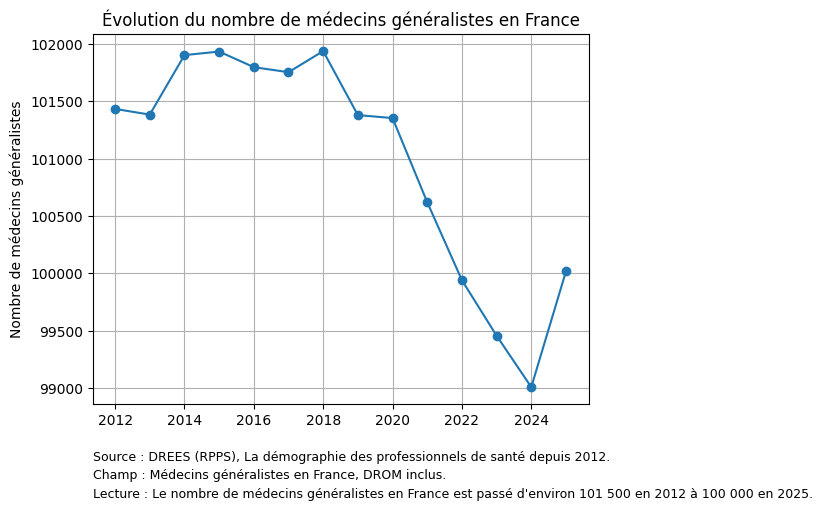

In [61]:
# Définition de la base de données réduite 
df = df_medecins_effectif[(df_medecins_effectif['exercice']=='0-Ensemble') 
    & (df_medecins_effectif['tranche_age']=='00-Ensemble') 
    & (df_medecins_effectif['region'] == '00-Ensemble') 
    & (df_medecins_effectif['territoire'] == "0-France entière")] 

# Définition des abscisses : années 2012 à 2025 
annees = list(range(2012,2026)) 

# Définition des ordonnées : effectifs des années 2012 à 2025 
effectifs = df[[f"effectif_{a}" for a in annees]].values.flatten() 
plt.plot(annees, effectifs, marker = "o") 

# Affichage du graphique plt.xlabel("Année") 
plt.ylabel("Nombre de médecins généralistes") 
plt.title("Évolution du nombre de médecins généralistes en France") 
plt.text(0, -0.16, "Source : DREES (RPPS), La démographie des professionnels de santé depuis 2012.", ha="left", va="bottom", fontsize=9, transform=plt.gca().transAxes) 
plt.text(0, -0.21, "Champ : Médecins généralistes en France, DROM inclus.", ha="left", va="bottom", fontsize=9, transform=plt.gca().transAxes) 
plt.text(0, -0.26, "Lecture : Le nombre de médecins généralistes en France est passé d'environ 101 500 en 2012 à 100 000 en 2025.", ha="left", va="bottom", fontsize=9, transform=plt.gca().transAxes) 

plt.grid(True)
plt.show()

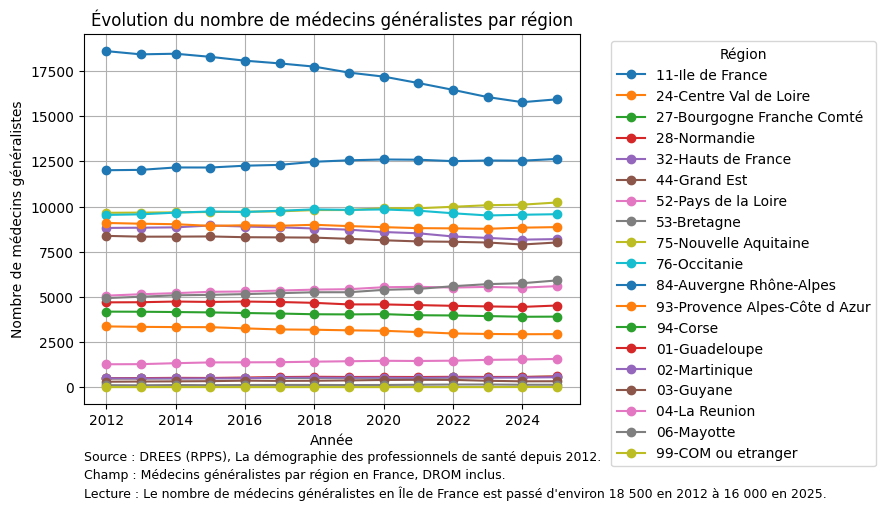

In [62]:
df = df_medecins_effectif[(df_medecins_effectif['exercice']=='0-Ensemble') & (df_medecins_effectif['tranche_age']=='00-Ensemble') & (df_medecins_effectif['region'] != '00-Ensemble')]
annees = list(range(2012,2026))


for region in df['region'].unique() :
    df_region = df[(df['region'] == region) & (df['departement'] == '000-Ensemble')]
    effectifs = df_region[[f"effectif_{a}" for a in annees]].values.flatten()
    plt.plot(annees, effectifs, label = region, marker = "o")

plt.xlabel("Année")
plt.ylabel("Nombre de médecins généralistes")
plt.title(f"Évolution du nombre de médecins généralistes par région")
plt.legend(title="Région", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.text(0, -0.16, "Source : DREES (RPPS), La démographie des professionnels de santé depuis 2012.", ha="left", va="bottom", fontsize=9, transform=plt.gca().transAxes) 
plt.text(0, -0.21, "Champ : Médecins généralistes par région en France, DROM inclus.", ha="left", va="bottom", fontsize=9, transform=plt.gca().transAxes) 
plt.text(0, -0.26, "Lecture : Le nombre de médecins généralistes en Île de France est passé d'environ 18 500 en 2012 à 16 000 en 2025.", ha="left", va="bottom", fontsize=9, transform=plt.gca().transAxes) 

plt.grid(True)
plt.show()